<a href="https://colab.research.google.com/github/alessioborgi/StyleAlignedDiffModels/blob/main/StyleAligned_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleAligned: Zero-Shot Style Alignment among a Series of Generated Images via Attention Sharing

### **Authors**: ***Borgi Alessio***, ***Danese Francesco***

### **Abstract**
In this notebook we aim to reproduce and enhance **[StyleAligned](https://arxiv.org/abs/2312.02133)**, a novel technique introduced by **Google Research**, for achieving **Style Consistency** in large-scale Text-to-Image (T2I) generative models. While current T2I models excel in creating visually compelling images from textual descriptions, they often struggle to maintain a consistent style across multiple images generated. Traditional methods to address this require extensive fine-tuning and manual intervention.

**StyleAligned** addresses this challenge by introducing minimal **Attention Sharing** during the **Diffusion Process**, ensuring **Style Alignment among generated images** without the need for optimization or fine-tuning (**Zero-Shoot Inference**). The method operates by leveraging a straightforward inversion operation to apply a reference style across various generated images, maintaining high-quality synthesis and fidelity to the provided text prompts.

### 0: SETTINGS & IMPORTS

#### 0.1: CLONE REPOSITORY AND GIT SETUP

In the following cell, we setup the code, by cloning the repository, setting up the Git configurations, and providing some other useful commands useful for git.  

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
!git config --global user.name "Alessio Borgi"
!git config --global user.email "alessioborgi3@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 232 (delta 27), reused 30 (delta 13), pack-reused 182
Receiving objects: 100% (232/232), 26.25 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/StyleAlignedDiffModels
imgs/              requirements.txt                  StyleAligned_Explanation.ipynb
inversion.py       sa_handler.py                     Style_Aligned_SDXL_old.ipynb
LICENSE            src/                              Style_Aligned_Transfer_SDXL.ipynb
pipeline_calls.py  Style_Aligned_ControlNet.ipynb    TO-DO.txt
README.md          StyleAligned_Explanation_1.ipynb


#### 0.2: INSTALL AND IMPORT REQUIRED LIBRARIES

We proceed then by installing and importing the required libraries.

In [5]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

In [6]:
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from __future__ import annotations
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline

T = torch.tensor # Create Alias for torch.tensor to increase readability.

In [9]:
TN = T

### 1: UTILS IMPLEMENTATION

#### 1.1: ADAIN MODULE

The **[Adaptive Instance Normalization (AdaIN)](https://arxiv.org/abs/1703.06868)** module is essential for **StyleAligned**. This works by first computing the mean and standard deviation of the input feature tensor $x$, independently for each feature map. The mean $\mu_x$ and standard deviation $\sigma_x$ are calculated as: $$\mu_x = \frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{ij}$$ and $$\sigma_x = \sqrt{\frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} (x_{ij} - \mu_x)^2 + \epsilon}$$ where $H$ and $W$ are the height and width of the feature map, respectively, and $\epsilon$ is a small constant for numerical stability. These statistics are then matched to those of the style features $y$ by normalizing the input features $x$ and then scaling and shifting them using the style's mean $\mu_y$ and standard deviation $\sigma_y$.

The transformed feature tensor is given by: $$\text{AdaIN}(x, y) = \sigma_y \left( \frac{x - \mu_x}{\sigma_x} \right) + \mu_y$$

AdaIN receives a content input $x$ and a style input $y$, and simply aligns the channel wise mean and variance of $x$ to match those of $y$.
This process enables the content to adopt the style's statistical properties, facilitating effective style transfer, adding almost no computational cost.

In the StyleAligned project, instead of applying this normalization on convolutional-extracted feature maps, we embed it in the self attention layer: the AdaIN module is utilized to normalize the Queries $Q_t$ and Keys $K_t$ of the target image using the Queries $Q_r$ and Keys $K_r$ of the reference image:

$$\hat Q_t = \text{AdaIN}(Q_t, Q_r) \;\;\;\;\;\;\;\;\;\;\;\;\;\; \hat K_t = \text{AdaIN}(K_t, K_r)$$

For the images in the first half of the batch, the reference image is the first one in the batch; for the second half of the batch the reference is the image in the middle of the entire batch (index = batchsize//2). Note that the middle image is dependent on the first one, therefore the same style is transmitted throughout the whole batch, while slightly increasing diversity.

**Appendix:**

How are Queries, Keys and Values constructed if the previous layer is a convolutional layer? Suppose the convolution resulted in a feature map of size (batch, channels, height, width); then each "pixel" is considered a token with its channels as dimensions/features of the token, resulting in *height $×$ width* tokens, ready to be projected into Q, K and V via learnable linear layers. (See image below)

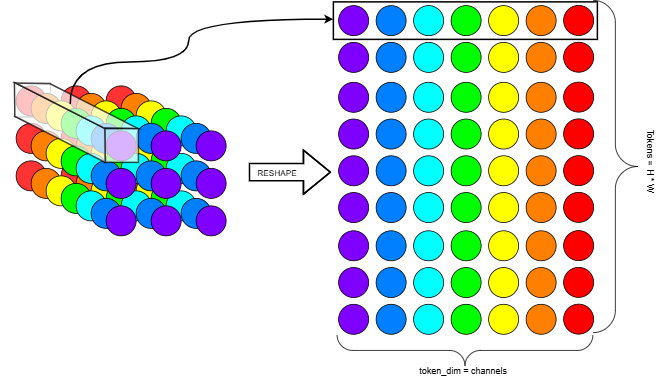

In [ ]:
#@title Ignore
'''
feat = torch.randn(16, 10, 1, 32)
b = feat.shape[0]
feat_style = torch.stack((feat[0], feat[b // 2])).unsqueeze(1)
print(feat_style.shape)
feat_style = feat_style.expand(2, b // 2, *feat.shape[1:])
print(feat_style.shape)
feat_style.reshape(*feat.shape).shape
'''

torch.Size([2, 1, 10, 1, 32])
torch.Size([2, 8, 10, 1, 32])


torch.Size([16, 10, 1, 32])

**Functions documention:**
* `calc_mean_std`  --->  Computes mean and standard deviations along the tokens ("pixels" see above) dimension of any Q or K passed, reference or target.
* `expand_first`  --->  Used both for AdaIN and Shared attention. When used for Adain, it takes as input the mean/std tensor of each Q/K in the batch, thus of shape (batch, heads, 1, channels). Expand this tensor by repeating the mean of the first img in the batch for all tokens of the first half of the batch, same thing with the midle ref img for the second half. Output shape -> (batch, heads, tokens, channels). It doeas a similar thing when it takes as input not mean or std but an entire Q or V, it simly does not need to repeat the statistics for each token since that dimension is already "filled" with their Q or V values. It just repeat the Q/V of the first image for the first half of the batch and as before, same thing fr the middle image and the second half of the batch.
* `concat_first`  --->  Used for shared attention, it concatenates the Q/V of the reference image (created by *expand_first*) with the ones of each actual target image along the tokens dimension resulting in shape -> (batch, heads, *tokens, dim_head). Dim_head is the head dimension after projecting the channels to be Q, K and V. Usually they all share the same dimension (even if V could be different).
* `AdaIN`  -->  Finally performs the adapative normalization using the previously computed statistics

In [10]:
# used only for shared attention
def concat_first(feat: T, dim=2, scale=1.) -> T: # takes K or V as input with shape = (batch, heads, tokens, dim_head)
    feat_style = expand_first(feat, scale=scale) # creates K/V of the two reference imgs (1th and middle-batch) of shape -> as above
    # feat_style holds the K/V of the first image repeated for the first half of the batch,
    # and of the middle img repeated for the second half of the batch
    return torch.cat((feat, feat_style), dim=dim) # concatenate the real K/V along the "tokens" dimensions, so that Q_target pays attention to both target and reference(s) Keys and Values tokens

# when this takes mean and std -> input shape: (batch, heads, 1, channels), see below
# when it takes K or V -> input shape: (batch, heads, tokens, dim_head), as used in "concat_first" above

def expand_first(feat: T, scale=1.,) -> T:
    b = feat.shape[0] # Extract batch size
    feat_style = torch.stack((feat[0], feat[b // 2])).unsqueeze(1) # shape: (2, 1, heads, 1, channels), stack the mean (or std) of first and middle images in the batch
    if scale == 1:
        # repeat the mean or std batch/2 times (since we are considering 2 stats, from first and middle img in the batch)
        feat_style = feat_style.expand(2, b // 2, *feat.shape[1:]) # shape: (2, batch//2, heads, 1, channels)
    else: # apply a scaling factor to the mean/std corresponding to all images except for the reference ones
        # the ref. imgs. will be normalized using THEIR unscaled stats thus they remain the SAME.
        feat_style = feat_style.repeat(1, b // 2, 1, 1, 1) # shape: (2, batch//2, heads, 1, channels) like "expand"
        feat_style = torch.cat([feat_style[:, :1], scale * feat_style[:, 1:]], dim=1)
    return feat_style.reshape(*feat.shape) # reshape so that first half of batch has assigned the mean/std of the first img, second half of the middle image

def calc_mean_std(feat, eps: float = 1e-5) -> tuple[T, T]:  # computes mean and std along number of tokens dimension
    feat_std = (feat.var(dim=-2, keepdims=True) + eps).sqrt()
    feat_mean = feat.mean(dim=-2, keepdims=True)
    return feat_mean, feat_std # output shape: (batch, heads, 1, channels)

def adain(feat: T) -> T: # Input shape: (Batch, Heads, #Tokens, Channels), #Tokens is number of "pixels" in the feature map, channels = dim_head = token_dim
    feat_mean, feat_std = calc_mean_std(feat)
    feat_style_mean = expand_first(feat_mean)
    feat_style_std = expand_first(feat_std)
    feat = (feat - feat_mean) / feat_std  # normalize the feature map
    feat = feat * feat_style_std + feat_style_mean  # scale and shift the feature map (reparameterization with reference stats)
    return feat

In [ ]:
attn = attention_processor.Attention(query_dim=32, dim_head = 64, heads = 8)
# both Q and K and V are projected from the input hidden states to a dimension that matches heads * dim_head.
# example: Projected from (Batch, tokens, 32) to (Batch, tokens, 512), and then reshaped to (Batch, tokens, 8 = heads, dim_head = 64).
attn

Attention(
  (to_q): Linear(in_features=32, out_features=512, bias=False)
  (to_k): Linear(in_features=32, out_features=512, bias=False)
  (to_v): Linear(in_features=32, out_features=512, bias=False)
  (to_out): ModuleList(
    (0): Linear(in_features=512, out_features=32, bias=True)
    (1): Dropout(p=0.0, inplace=False)
  )
)

### Shared Attention Mechanism

Combined with AdaIN, the key mechanism employed for achieving style alignment is Shared Attention. The standard Self-Attention operation is the following:
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d}})V$$
Computed *independently* for each Q,V,K in the batch. With shared attention, each image *i* in the batch will perform an extended self-attention, not only "attending" to it's own keys and values but also to the one of a reference image (the first of the batch) from which we want to transfer the style. Therefore we concatenate the Keys and Values of the actual image in the batch with the ones of the choosen reference image along the "#tokens" dimension: $K_{rt} = [K_r\, |\, \hat{K_t}]$ and $V_{rt} = [V_r \, |\, V_t]$
Finally, after the AdaIN and this concatenation, the shared attention operation is simply:
$$Attention(\hat{Q}, K_{rt}, V_{rt})$$

### Requirements for Custom Attention Processor

1. **Subclass `nn.Module`:**
   Your custom attention processor should inherit from `torch.nn.Module`.

2. **Implement `__call__` Method:**
   The `__call__` method is essential. It should accept the following parameters and return the processed attention output:
   - `attn`: An instance of `attention_processor.Attention`.
   - `hidden_states`: The hidden states to be processed.
   - `encoder_hidden_states`: Optional; used for cross-attention.
   - `attention_mask`: Optional; used to mask certain positions.

3. **Utilize Existing Projections (Q, K, V):**
   To retain the pre-trained weights for the Q, K, V projections, your processor should use the existing projections from the `Attention` instance. This can be done by accessing `attn.to_q`, `attn.to_k`, and `attn.to_v`.

4. **Handle Optional Elements:**
   The `__call__` method should properly handle optional elements such as `encoder_hidden_states` and `attention_mask`, ensuring flexibility in the types of attention (self-attention vs. cross-attention).


In [11]:
class DefaultAttentionProcessor(nn.Module):

    def __init__(self):
        super().__init__()
        self.processor = attention_processor.AttnProcessor2_0() # from diffusers.models import attention_processor

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None,
                 attention_mask=None, **kwargs):
        return self.processor(attn, hidden_states, encoder_hidden_states, attention_mask)

class SharedAttentionProcessor(DefaultAttentionProcessor):

    def shifted_scaled_dot_product_attention(self, attn: attention_processor.Attention, query: T, key: T, value: T) -> T:
      # don't be scare by Einstein notation, it's a "fancy" way to do matrix multiplication, here the dot product in attn. QK^T.
      # Recall query shape: (batch, heads, tokens, dim) while key shape: (batch, heads, 2*tokens, dim) since it has the ref. also
      logits = torch.einsum('bhqd,bhkd->bhqk', query, key) * attn.scale # should be equal to "logits = torch.matmul(query, key.transpose(-1, -2)) * attn.scale " and scale should be 1/sqrt(dim)
      # logits shape: (batch, heads, tokens, 2*tokens)
      logits[:, :, :, query.shape[2]:] += self.style_alignment_score_shift # shift by a scalar the attn weights corresponding ONLY to the REFERENCE Keys (see slicing).
      probs = logits.softmax(-1) # softmax along the attention weights of 1 token w.r.t every other token
      return torch.einsum('bhqk,bhkd->bhqd', probs, value) # last dot product with V

    def shared_call(
            self,
            attn: attention_processor.Attention,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            **kwargs
    ):

        residual = hidden_states
        input_ndim = hidden_states.ndim
        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2) # result shape (batch, #tokens, channel) as in the above picture

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states) # linear layer "channels" -> "heads * dim_heads"
        key = attn.to_k(hidden_states) # same as above
        value = attn.to_v(hidden_states) # same as above
        inner_dim = key.shape[-1] # get "heads * dim_heads" value
        head_dim = inner_dim // attn.heads # infer "dim_head" by dividing for the number of heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # shape all back to (batch, heads, tokens, dim_head)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # same as above
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) # same as above
        # if self.step >= self.start_inject:
        # Adaptive Normalization of Q and K (and eventually V)
        if self.adain_queries:
            query = adain(query)
        if self.adain_keys:
            key = adain(key)
        if self.adain_values: # usually false
            value = adain(value)
        # shared attention layer
        # Q, V and K shape = (batch, heads, tokens, dim_head)
        if self.share_attention:
            key = concat_first(key, -2, scale=self.style_alignment_score_scale) # create Keys = [K_t, K_r] -> shape: (batch, heads, 2*tokens, dim_head)
            value = concat_first(value, -2) # create Values = [V_t, V_r] -> shape: (batch, heads, 2*tokens, dim_head)
            if self.style_alignment_score_shift != 0:
                hidden_states = self.shifted_scaled_dot_product_attention(attn, query, key, value,)
            else:
                hidden_states = nnf.scaled_dot_product_attention(
                    query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
                ) # hidden_states output shape -> (batch, heads, tokens, dim_head) since Q not double (.,.,tokens,.) and att = softmax(Q * K'/sqrt(dim_head)) * V
        else:
            hidden_states = nnf.scaled_dot_product_attention(
                query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            )

        # now heads concatenation for later re-projection as in standard Multi Head Attention
        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim) # transpose -> (b, t, h, d_h); reshape -> (b, t, h*d_h)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states) # to_out[0] = Linear(in_features = heads * dim_heads, out_features = dim_heads, bias=True)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)
        # hidden_states shape -> (batch, tokens, dim_head) = (batch, pixels, channels)
        if input_ndim == 4:
            # shape it back to a "feature_maps" ready for convolution
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width) # transpose -> (b, c, pixels); reshape to create an "image" -> (b, c, h, w)

        if attn.residual_connection:
            hidden_states = hidden_states + residual # residuals were initial input hidden_states untouched, before attention mechanismf

        hidden_states = hidden_states / attn.rescale_output_factor
        return hidden_states

    def __call__(self, attn: attention_processor.Attention, hidden_states, encoder_hidden_states=None,
                 attention_mask=None, **kwargs):

        hidden_states = self.shared_call(attn, hidden_states, hidden_states, attention_mask, **kwargs)

        return hidden_states

    def __init__(self, style_aligned_args: StyleAlignedArgs):
        super().__init__()
        self.share_attention = style_aligned_args.share_attention
        self.adain_queries = style_aligned_args.adain_queries
        self.adain_keys = style_aligned_args.adain_keys
        self.adain_values = style_aligned_args.adain_values
        self.style_alignment_score_scale = style_aligned_args.style_alignment_score_scale
        self.style_alignment_score_shift = style_aligned_args.style_alignment_score_shift

In [12]:
from dataclasses import dataclass

@dataclass(frozen=True)
class StyleAlignedArgs:
    share_group_norm: bool = True
    # Indicates whether to share group normalization across the model.
    share_layer_norm: bool = True
    # Indicates whether to share layer normalization across the model.
    share_attention: bool = True
    # Indicates whether to share attention mechanisms across the model.
    adain_queries: bool = True
    # Indicates whether to apply AdaIN (Adaptive Instance Normalization) to the queries.
    adain_keys: bool = True
    # Indicates whether to apply AdaIN to the keys.
    adain_values: bool = False
    # Indicates whether to apply AdaIN to the values.
    only_self_level: float = 0.0
    #
    style_alignment_score_scale: float = 1.0
    # Scale factor for the shared attn.
    style_alignment_score_shift: float = 0.0
    # Shift factor for the shared attn.

In [13]:
def _get_switch_vec(total_num_layers, level): # level is percentage of layers to keep (just self.attn). Output what layers to switch to shared attn.
    if level == 0:
        return torch.zeros(total_num_layers, dtype=torch.bool) # change everything so output a full zero (false) vector
    if level == 1:
        return torch.ones(total_num_layers, dtype=torch.bool) # keep all layers so a full one (true) vector
    to_flip = level > .5 # if level is above half, we have compute as it if was 1 - level and then take the complement (not = ~) of the resulting vector
    if to_flip:
        level = 1 - level
    num_switch = int(level * total_num_layers) # number of layers to keep rounded down
    vec = torch.arange(total_num_layers) # creates vector = [0, 1, 2, 3, ..., tot_num_layers]
    vec = vec % (total_num_layers // num_switch) # put a zero on each layer to keep (1 every tot_num//num_switch).
    # E.G every 3 layer keep 1 -> [0, 1, 2, 0, 1, 2, 0, 1, ...].
    vec = vec == 0 # boolean mask
    # The % is not okay when level > 0.5 since it alway gives 1, that's why we make the flipping trick
    if to_flip:
        vec = ~vec
    return vec # return a boolean mask vector indicating which layer to keep (true) and which to switch (false) to custom shared attn.

def init_attention_processors(pipeline: StableDiffusionXLPipeline, style_aligned_args: StyleAlignedArgs | None = None):
    attn_procs = {}
    unet = pipeline.unet # extract the Unet from the StableDiffusionXLPipeline
    number_of_self, number_of_cross = 0, 0 # these two variables are like...useless but ok just in case for counting/debugging
    num_self_layers = len([name for name in unet.attn_processors.keys() if 'attn1' in name]) # count number of self_attn layers (i.e the ones with "attn1" in the name)
    if style_aligned_args is None:
        only_self_vec = _get_switch_vec(num_self_layers, 1) # indicates to switch all self attn. layers to shared attn.
    else:
        only_self_vec = _get_switch_vec(num_self_layers, style_aligned_args.only_self_level) # indicate to switch some self attn. layers to shared attn dependeing on level arg
    # Iterate through all layers: if cross.attn = default attn; if self.attn = switch to shared depending on switch vec computed with "level" arg
    for i, name in enumerate(unet.attn_processors.keys()):
        is_self_attention = 'attn1' in name
        if is_self_attention:
            number_of_self += 1
            # recall only_self_vec is long "number of self.attn layers" not al layers
            if style_aligned_args is None or only_self_vec[i // 2]: # I SUPPOSE self attn and cross attn layers are alternating, so i//2
                attn_procs[name] = DefaultAttentionProcessor()
            else:
                attn_procs[name] = SharedAttentionProcessor(style_aligned_args)
        else:
            number_of_cross += 1
            attn_procs[name] = DefaultAttentionProcessor()
    # Library call -> set all assigned attention processors classes (see markdown to know how to implement those). No weights changed.
    unet.set_attn_processor(attn_procs)


def register_shared_norm(pipeline: StableDiffusionXLPipeline,
                         share_group_norm: bool = True,
                         share_layer_norm: bool = True, ):
    def register_norm_forward(norm_layer: nn.GroupNorm | nn.LayerNorm) -> nn.GroupNorm | nn.LayerNorm:
        # register the original forward method as an attribute (creates one if not present)
        if not hasattr(norm_layer, 'orig_forward'):
            setattr(norm_layer, 'orig_forward', norm_layer.forward)
        orig_forward = norm_layer.orig_forward

        def forward_(hidden_states: T) -> T: # perform Group/Layer Normalization with reference img.
            n = hidden_states.shape[-2] # hs shape: (batch, head, #tokens, channels). Channels and dim_head are synonym in this notebook.
            hidden_states = concat_first(hidden_states, dim=-2) # concat with reference img hidden_states shape (b, h, 2*t, c)
            hidden_states = orig_forward(hidden_states) # original normalization this time with also reference hidden states
            return hidden_states[..., :n, :] # retain just original hidden states ("tokens") i.e. the first half of them

        norm_layer.forward = forward_ #set the new forward that will first concat. the ref. features and then call the original forward
        return norm_layer

    # get the normalization layers from the pipeline iterating it recursively and save them in a dictionary
    def get_norm_layers(pipeline_, norm_layers_: dict[str, list[nn.GroupNorm | nn.LayerNorm]]):
        if isinstance(pipeline_, nn.LayerNorm) and share_layer_norm:
            norm_layers_['layer'].append(pipeline_)
        if isinstance(pipeline_, nn.GroupNorm) and share_group_norm:
            norm_layers_['group'].append(pipeline_)
        else:
            for layer in pipeline_.children():
                get_norm_layers(layer, norm_layers_)

    norm_layers = {'group': [], 'layer': []}
    get_norm_layers(pipeline.unet, norm_layers)
    # modify the norm layers making them shared
    return [register_norm_forward(layer) for layer in norm_layers['group']] + [register_norm_forward(layer) for layer in
                                                                               norm_layers['layer']]

In [14]:
class Handler:

    def register(self, style_aligned_args: StyleAlignedArgs, ):
        self.norm_layers = register_shared_norm(self.pipeline, style_aligned_args.share_group_norm,
                                                style_aligned_args.share_layer_norm)
        init_attention_processors(self.pipeline, style_aligned_args) # modify the pretrained architecture adding AdaIN & Shared Attention

    def remove(self): # this "restore" the original architecture, removing any altered layer
        for layer in self.norm_layers:
            layer.forward = layer.orig_forward
        self.norm_layers = []
        init_attention_processors(self.pipeline, None)

    def __init__(self, pipeline: StableDiffusionXLPipeline):
        self.pipeline = pipeline
        self.norm_layers = []

### 4: DDIM \& PIPELINE DEFINITION
We then proceed to load the **SDXL (Stable Diffusion XL)** Model and configure the **DDIM (Denoising Diffusion Implicit Models) Scheduler**. We then configure the **Pipeline**.

#### 4.1: DDIM SCHEDULER

The **DDIM Scheduler** is the component used in diffusion models for generating high-quality samples from noise. It controls the denoising process by defining a schedule for adding and removing noise to and from the data. The scheduler is essential in determining how the model transitions from pure noise to a final, coherent image or other data form.

In particular, its parameters are:
- **beta_start (float)**: Starting value of beta, the variance of the noise schedule.
- **beta_end (float)**: Ending value of beta, the variance of the noise schedule.
- **beta_schedule (str)**: The type of schedule for beta. (Possible values: "linear", "scaled_linear", "squaredcos_cap_v2", "sigmoid").
- **clip_sample (bool)**: If True, the samples are clipped to [-1, 1].
- **set_alpha_to_one (bool)**: If True, alpha will be set to 1 at the end of the sampling process.
- **num_train_timesteps (int)**: The number of diffusion steps used during training.
- **timestep_spacing (str)**: The method to space out timesteps.(Possible values: "linspace", "leading").
- **prediction_type (str)**: The type of prediction model used in the scheduler. (Possible values: "epsilon", "sample", "v-prediction").
- **trained_betas (torch.Tensor or None)**: Optional tensor of pre-trained betas to use in the scheduler.

##### 4.1.1: DIFFUSION PROCESS

The diffusion process involves adding noise to the data over a series of timesteps, which is described by the forward process:

$$ q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{\alpha_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}) $$

where:
- $\alpha_t$ and $\beta_t$ are the scaling and noise variance terms, respectively.

##### 4.1.2: REVERSE PROCESS

The reverse process aims to recover the data by denoising it, and is given by:

$$ p_{\theta}(\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_{\theta}(\mathbf{x}_t, t), \sigma_t^2 \mathbf{I}) $$

where:
- $\mu_{\theta}(\mathbf{x}_t, t)$ is the predicted mean.
- $\sigma_t$ is the standard deviation of the noise at timestep $t$.

##### 4.1.3: BETA SCHEDULE

The beta values are scheduled over timesteps from `beta_start` to `beta_end`. The schedule can be:
- **Linear**:

$$ \beta_t = \beta_{\text{start}} + t \frac{\beta_{\text{end}} - \beta_{\text{start}}}{T} $$

- **Scaled Linear**:

$$ \beta_t = \beta_{\text{start}} + t \left(\frac{\beta_{\text{end}} - \beta_{\text{start}}}{T}\right)^2 $$

- **Sigmoid**:

$$ \beta_t = \beta_{\text{start}} + (\beta_{\text{end}} - \beta_{\text{start}}) \cdot \text{sigmoid}(t) $$

- **Squared Cosine (squaredcos\_cap\_v2)**:

$$ \beta_t = \beta_{\text{start}} + 0.5 \left(1 - \cos\left(\frac{t \pi}{T}\right)\right) (\beta_{\text{end}} - \beta_{\text{start}}) $$

##### 4.1.4: INFERENCE WITH DDIM

During inference, the denoising process can be described as:

$$ \mathbf{x}_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{\mathbf{x}_t - \sqrt{1 - \alpha_t} \mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t)}{\sqrt{\alpha_t}} \right) + \sqrt{1 - \alpha_{t-1} - \sigma_t^2} \mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t) $$

where:
- $\mathbf{\epsilon}_{\theta}(\mathbf{x}_t, t)$ is the noise predicted by the model.
- $\sigma_t$ is the standard deviation for the timestep $t$.

In [ ]:
scheduler_linear = DDIMScheduler(
    beta_start=0.00085,                 # Starting value of beta
    beta_end=0.012,                     # Ending value of beta
    beta_schedule="scaled_linear",      # Type of schedule for beta values
    clip_sample=False,                  # Whether to clip samples to a specified range
    set_alpha_to_one=False,             # Whether to set alpha to one at the end of the process

    num_train_timesteps=1000,           # Number of diffusion steps used during training
    timestep_spacing="linspace",        # Method to space out timesteps
    prediction_type="epsilon",          # Type of prediction model used in the scheduler
    trained_betas=None                  # Optional pre-trained beta values
)

scheduler = scheduler_linear

### 4.2: SDXL PIPELINE DEFINITION

We then proceed to **load** the **pre-trained `StableDiffusionXLPipeline` model** with specific configurations to optimize for GPU memory usage and ensure efficient processing. Below is a breakdown of each parameter and its purpose:

- **pretrained_model_name_or_path**: The name or path of the pre-trained model to be loaded. In this example, we use `"stabilityai/stable-diffusion-xl-base-1.0"`, which is a pre-trained model available in the Stability AI repository.
- **torch_dtype**: Specifies the data type for the model's tensors. Here, `torch.float16` is used to enable mixed precision, which helps reduce memory usage and improve computation speed.
- **variant**: Indicates the model variant. `"fp16"` is used to specify 16-bit floating point precision, aligning with the `torch_dtype` parameter.
- **use_safetensors**: Determines whether to use the `safetensors` library for safe tensor loading. Setting this to `True` ensures safer model loading.
- **scheduler**: An instance of the scheduler to be used for the diffusion process. In this example, we use a `DDIMScheduler` instance configured for efficient sampling.
- **revision**: Specifies the model version to use. The default value is `None`, which means the latest version will be used.
- **use_auth_token**: The authentication token used for accessing private models. The default value is `None`, meaning no authentication is required.
- **cache_dir**: The directory where the downloaded model will be cached. The default value is `None`, which uses the default cache directory.
- **force_download**: Forces the model to be downloaded even if it exists locally. The default value is `False`.
- **resume_download**: Resumes a partial download if available. The default value is `False`.
- **proxies**: A dictionary of proxy servers to use. The default value is `None`, meaning no proxies are used.
- **local_files_only**: Uses only local files if set to `True`. The default value is `False`.
- **device_map**: Specifies device placement for model layers. The default value is `None`, which uses the default placement.
- **max_memory**: Specifies the maximum memory allowed for each device. The default value is `None`, meaning no specific memory limit is set.

Finally, the model is moved to the GPU for faster computations using `.to("cuda")`.

The use of mixed precision (`torch_dtype=torch.float16` and `variant="fp16"`) helps in reducing memory usage and improving performance. This configuration is particularly useful when working with large models and limited GPU memory.

In [ ]:
SDXL_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0",  # The model name or path
    torch_dtype=torch.float16,            # Data type for the model's tensors
    variant="fp16",                       # Model variant for 16-bit floating point precision (Mixed Precision)
    use_safetensors=True,                 # Use the safetensors library for safe tensor loading
    scheduler=scheduler,                  # Scheduler instance for the diffusion process

    revision=None,                        # Model version to use, default is None
    use_auth_token=None,                  # Authentication token, None means no authentication
    cache_dir=None,                       # Directory to cache the downloaded model, None uses default
    force_download=False,                 # Force download even if the model exists locally
    resume_download=False,                # Resume a partial download if available
    proxies=None,                         # Dictionary of proxy servers to use, None means no proxies
    local_files_only=False,               # Use only local files if set to True
    device_map=None,                      # Device placement for model layers, None uses default placement
    max_memory=None                       # Maximum memory allowed for each device, None means no specific limit
).to("cuda")                              # Move the model to the GPU for faster computations

In [ ]:
handler = Handler(SDXL_Pipeline)
sa_args = StyleAlignedArgs(share_group_norm=False,
                                      share_layer_norm=False,
                                      share_attention=True,
                                      adain_queries=True,
                                      adain_keys=True,
                                      adain_values=False
                                     )

handler.register(sa_args)

## 5: STYLE-ALIGNED WITH ONLY PROMPTS (WITHOUT REFERENCE IMAGE)

In [ ]:
# run StyleAligned

sets_of_prompts = [
  "a toy train. macro photo. 3d game asset",
  "a toy airplane. macro photo. 3d game asset",
  "a toy bicycle. macro photo. 3d game asset",
  "a toy car. macro photo. 3d game asset",
  "a toy boat. macro photo. 3d game asset",
]
images = SDXL_Pipeline(sets_of_prompts,).images
mediapy.show_images(images)

TO RUN IF YOU HAVEN'T ENOUGH GPU RAM

In [ ]:
# run StyleAligned
sets_of_prompts = [
  "a toy train. macro photo. 3d game asset",
  "a toy airplane. macro photo. 3d game asset",
  "a toy bicycle. macro photo. 3d game asset",
  "a toy car. macro photo. 3d game asset",
  "a toy boat. macro photo. 3d game asset",
]
# sets_of_prompts = [
#   "a hot hair balloon, simple wooden statue",
#   "a friendly robot, simple wooden statue",
#   "a bull, simple wooden statue",
# ]
images = []
for prompt in sets_of_prompts:
    # Generate image for each prompt individually
    image = SDXL_Pipeline([prompt]).images[0]
    images.append(image)
    # Clear CUDA cache to free memory
    torch.cuda.empty_cache()

    # Print Memory summary
    # print(torch.cuda.memory_summary(device=None, abbreviated=False))

mediapy.show_images(images)

## 6: STYLE-ALIGNED WITH REFERENCE IMAGE

In this section, we develop the **StyleAligned** method that **maintains visual coherence** w.r.t. a **Reference Style Image**.


#### 6.1: LOADING REFERENCE IMAGE & SETTING PARAMETERS

As first thing, we **load a Reference Image** from which you will "copy the style". Indeed, we will ask for the newly generated images to stick with the same style of the Reference image, i.e., to be **Style-Aligned**.
In particular, we will define 3 **Image Parameters** here:
- **reference_style**: This is the reference style describing the reference image.
- **reference_prompt**: This is the reference prompt describing the reference image.
- **reference_image_path**: This is the path to the reference image.

As second step, you will set the parameters relative to the **Diffusion Inversion Process**. This process in a.k.a as **Temperature Scaling**, that aims to inject confidence/randomness in a classification/generation model. In this case, we aim at injecting more styleAlignment or randomness to the image generated.

In particular, you will set the parameters relative to:
- **num_inference_steps**: The number of inference steps to be performed during the Diffusion Inversion Process.
- **guidance_scale**: Here we set the parameter to have **Guidance Scale**, a parameter used in **guided diffusion models** to control the influence of the conditioning signal (e.g., a text prompt) during the image generation process, with the purpose to balance the model’s adherence to the conditioning signal and its natural generative tendencies. In particular:
	- **High Guidance Scale (>1)**: Increases the influence of the conditioning signal, making the generated images more aligned with the prompt. The model is more likely to produce images with features that are explicitly described in the prompt, leading to more detailed and specific outputs. Very high values might cause the model to overfit to the prompt, potentially losing some naturalness or introducing artifacts.
	- **Default Guidance Scale (=1)**: A guidance scale of 1.0 means that the model’s predictions are equally balanced between the conditional and unconditional signals, providing a baseline level of adherence to the prompt.
	- **Low Guidance Scale (<1)**: A lower guidance scale reduces the effect of the guiding input, making the generated images less constrained by the prompt. The model has more freedom to generate diverse and potentially more creative outputs that are not strictly bound to the prompt. Very low values might cause the model to generate images that are too generic and not sufficiently aligned with the prompt.
- **style_alignment_score_shift**: This parameter is used to **shift** the **scores logarithmically**. In particular, we will have:
	- **High Values (>1)**: This will **increase** the **StyleAlignment**, making therefore the output image to be closer to the reference.
	- **Low Values (<=1)**: This will **decrease** the **StyleAlignment**, making therefore the output image to be farther to the reference.
- **style_alignment_score_scale**: This parameter is used to **scale** the scores or weights within the model. More in detail:
	- **High Values (>1)**: This increases the magnitude of the scores, making the model more confident and therefore not varying so much the generation process.
	- **Standard Value (=1)**: This translates in having no rescaling.
	- **Low Values (<1)**: This coincides to having more generalization (injecting randomness) into the generation process.

***Special Configuration for Famous Images***

For very famous images, it might be beneficial to suppress the **Shared Attention** to the reference image to avoid overfitting or excessive influence from the reference.

In [15]:
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False)

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    scheduler=scheduler
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
# 1) Medieval Painting
# Set the source style, prompt and path.
reference_style = "medieval painting"
reference_prompt = f'Man laying in a bed, {reference_style}.'
reference_image_path = './imgs/medieval-bed.jpeg'

# 2) Cubism Painting
# reference_style = "cubism painting"
# reference_prompt = f'Two men smoking water pipe, {reference_style}.'
# reference_image_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'


# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
style_alignment_score_shift = 2  # higher value induces higher fidelity, set 0 for no shift
style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
# style_alignment_score_shift = 1
# style_alignment_score_scale = 0.5


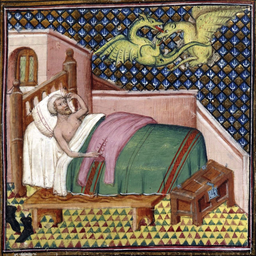

In [17]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

#### 6.2: FUNCTION FOR PROMPT TOKENIZATION & EMBEDDING

Hereafter, we aim to create the function that, taking a **text prompt** in **input**, **tokenizes** it through a Tokenizer, and then generates **embeddings** using a text encoder.

It will then return in output both the **Hidden State Embeddings** (contextual representations for each token from the second last layer of the text encoder) and the **Pooled Output Embeddings** (single vector representation capturing the overall meaning of the input text). If the prompt is empty, it returns zero tensors as negative embeddings.

In [18]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

The function we will develop for this is going to receive as Parameters:
- ***prompt***: A string containing the text prompt to be tokenized and embedded.
- ***tokenizer***: An instance of a tokenizer, used to convert the text prompt into token IDs.
- ***text_encoder***: An instance of a text encoder, used to generate embeddings from the token IDs.
- ***device***: The device (e.g., CPU or GPU) to run the computations on.

The steps involved are:
- **1) Tokenize the Input Prompt**: Converts the input text (prompt) into a sequence of tokens, which are numerical representations (token IDs) that can be processed by the model.
- **2) Extract Token IDs**: Extracts the token IDs from the tokenized inputs.
- **3) Generate Embeddings**: Generates embeddings for the tokenized input using the text encoder.
- **4) Extract Pooled Output Embeddings**: Extracts the pooled output embeddings, summarizing the input sequence.
- **5) Extract Hidden State Embeddings**: Extracts the hidden state embeddings from the second last layer of the text encoder.
- **6) Handle Empty Prompt Case**: Checks if the input prompt is empty and handles this case.
- **7) Return Embeddings**: Returns the generated embeddings.

In [19]:
def prompt_tokenizazion_and_embedding(prompt: str, tokenizer, text_encoder, device):

    # 1) Tokenize the Input Prompt: Tokenize the input prompt using the provided tokenizer, with padding and truncation.
    prompt_tokenized = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
    # 2) Extract Token IDs: Extract the input IDs (token indices) from the tokenized inputs.
    prompt_tokenized_ids = prompt_tokenized.input_ids

    # 3) Generate Embeddings: Use torch.no_grad() to disable gradient computation for the following operations.
    with torch.no_grad():
        # Generate embeddings for the tokenized input IDs using the text encoder.
        # The embeddings include output hidden states.
        prompt_embeddings = text_encoder(
            prompt_tokenized_ids.to(device),  # Move input IDs to the specified device (e.g., GPU).
            output_hidden_states=True,  # Request hidden states from the encoder.
        )

    # 4) Extract Pooled Output Embeddings: Extract the pooled output embeddings (first element of the tuple returned by the encoder).
    pooled_prompt_embeddings = prompt_embeddings[0]
    # 5) Extract Hidden State Embeddings: Extract the hidden state embeddings from the second last layer of the encoder.
    prompt_embeddings = prompt_embeddings.hidden_states[-2]

    # 6) Handle Empty Prompt Case: If the prompt is empty, return zero tensors as Negative Embeddings.
    if prompt == '':
        # Create a zero tensor with the same shape as the hidden state embeddings.
        negative_prompt_embeddings = torch.zeros_like(prompt_embeddings)
        # Create a zero tensor with the same shape as the pooled output embeddings.
        negative_pooled_prompt_embeddings = torch.zeros_like(pooled_prompt_embeddings)
        # Return the zero tensors for both negative embeddings and pooled negative embeddings.
        return negative_prompt_embeddings, negative_pooled_prompt_embeddings

    # 7) Returns the generated embeddings: Return the hidden state embeddings and the pooled output embeddings.
    return prompt_embeddings, pooled_prompt_embeddings

#### 6.4: TEXT EMBEDDING ENSEMBLE METHOD

In order to **enhance** the **model’s understanding** and **representation** of the **input text**, we proceed to generate and process text embeddings for a given prompt using **2 Different Text Tokenizers and Encoders**. We then prepares these embeddings and additional time IDs for conditioning within the StableDiffusionXLPipeline. We then return a dictionary containing the pooled embeddings and generated time IDs, as well as the concatenated text embeddings.

This choice has several advantages:
- Richness of Representation
- Combination of Different Models Strength
- Reducing Overfitting
- Enhancing Conditioning
- Improving Performance

In particular, the function receives the following **parameters**:
- ***model***: An instance of StableDiffusionXLPipeline.
- ***prompt***: A string containing the text prompt to be tokenized and embedded.

The steps involved are:
- **1) Get the Device**: Retrieve the device (e.g., CPU or GPU) on which the model is being executed.
- **2) Generate Text Embeddings**: Generate text embeddings using two different pairs of tokenizers and text encoders.
- **3) Concatenate Prompt Embeddings**: Concatenate the embeddings from the two sets of encoders along the last dimension.
- **4) Get Text Encoder Projection Dimension**: Retrieve the projection dimension from the configuration of the second text encoder.
- **5) Generate Additional Time IDs**: Generate additional time IDs required for conditioning.
- **6) Prepare Additional Condition Keyword Arguments**: Checks if the input prompt is empty and handles this case.
- **7) Return the Additional Condition Keyword Arguments and Concatenated Embeddings**: Return the prepared additional condition keyword arguments and concatenated prompt embeddings.


In [20]:
def embeddings_ensemble(model: StableDiffusionXLPipeline, prompt: str) -> tuple[dict[str, T], T]:

    # 1) Get the Device: Get the device (e.g., CPU or GPU) on which the model is being executed.
    device = model._execution_device

    # 2) Generate Text Embeddings:
    # Generate text embeddings using the first set of tokenizer and text encoder.
    prompt_embeddings_1, pooled_prompt_embeddings_1 = prompt_tokenizazion_and_embedding(prompt, model.tokenizer, model.text_encoder, device)

    # Generate text embeddings using the second set of tokenizer and text encoder.
    prompt_embeddings_2, pooled_prompt_embeddings_2 = prompt_tokenizazion_and_embedding(prompt, model.tokenizer_2, model.text_encoder_2, device)

    # 3) Concatenate Prompt Embeddings: Concatenate the embeddings from both sets of encoders along the last dimension.
    prompt_embeddings_concat = torch.cat((prompt_embeddings_1, prompt_embeddings_2), dim=-1)

    # 4) Get Text Encoder Projection Dimension: Retrieve the projection dimension from the configuration of the second text encoder
    prompt_encoder_projection_dim = model.text_encoder_2.config.projection_dim

    # 5) Generate Additional Time IDs: Generate additional time IDs required for conditioning.
    conditioning_time_ids = model._get_add_time_ids((1024, 1024), (0, 0), (1024, 1024), torch.float16, prompt_encoder_projection_dim).to(device)

    # 6) Prepare Additional Condition Keyword Arguments: Prepare additional condition keyword arguments required for the model.
    conditioning_kwargs = {"text_embeds": pooled_prompt_embeddings_2, "time_ids": conditioning_time_ids}

    # 7) Return the Additional Condition Keyword Arguments and Concatenated Embeddings:Return the prepared additional condition keyword arguments and concatenated prompt embeddings
    return conditioning_kwargs, prompt_embeddings_concat

#### 6.5: TEXT EMBEDDING: NEGATIVE CONDITIONING TECHNIQUE

We then proceed to **generate Text Embeddings** and **Conditioning Keywords** for both the **Given Prompt** and an **Empty Prompt** (used for **Negative Conditioning**). We concatenate these embeddings and keywords to create a combined representation that includes both positive and negative contexts.

These input prompts are used to guide the generation process in diffusion models (through **Guidance**) and improving the quality of generated outputs by considering **what the model should not generate (negative conditioning)**.

The **benefits** we get from this technique are:
- **Balanced Representation**
- **Improved Semantic Understanding**
- **Reduction of Noise**

In particular, the function receives the following **parameters**:
- ***model***: An instance of StableDiffusionXLPipeline.
- ***prompt***: A string containing the text prompt to be tokenized and embedded.

The steps involved are:
- **1) Encode Text with Given Prompt using Text Embedding Ensemble**: Generate text embeddings and conditioning keywords for the given text prompt.
- **2) Encode Text with Empty Prompt**: Generate text embeddings and conditioning keywords for an empty prompt (negative conditioning).
- **3) Concatenate Positive and Negative Embeddings**: Concatenate the embeddings from the negative and positive prompts.
- **4) Concatenate Positive and Negative Conditioning Keyword**: Concatenate the conditioning keywords from the negative and positive prompts.
- **5) Return Combined Conditioning Keywords and Embeddings**: Return the combined conditioning keywords and concatenated embeddings.

In [21]:
def embeddings_ensemble_with_neg_conditioning(model: StableDiffusionXLPipeline, prompt: str) -> tuple[dict[str, T], T]:
    # 1) Encode Text with Given Prompt using Text Embedding Ensemble Encode Text with Given Prompt: Generate text embeddings and conditioning keywords for the given prompt.
    conditioning_kwargs, prompt_embeddings_concat = embeddings_ensemble(model, prompt)

    # 2) Encode Text with Empty Prompt: Generate text embeddings and conditioning keywords for an empty prompt (negative conditioning).
    unconditioning_kwargs, prompt_embeddings_uncond = embeddings_ensemble(model, "")

    # 3) Concatenate Positive and Negative Embeddings: Concatenate the embeddings from the negative and positive prompts.
    prompt_embeddings_concat = torch.cat((prompt_embeddings_uncond, prompt_embeddings_concat))

    # 4) Concatenate Positive and Negative Conditioning Keywords: Concatenate the conditioning keywords from the negative and positive prompts.
    conditioning_unconditioning_kwargs = {
        "text_embeds": torch.cat((unconditioning_kwargs["text_embeds"], conditioning_kwargs["text_embeds"])),
        "time_ids": torch.cat((unconditioning_kwargs["time_ids"], conditioning_kwargs["time_ids"]))
    }

    # 5) Return Combined Conditioning Keywords and Embeddings: Return the combined conditioning keywords and concatenated embeddings.
    return conditioning_unconditioning_kwargs, prompt_embeddings_concat

#### 6.6: ENCODE THE REFERENCE IMAGE

We now switch our attention to the **Reference Image**. This is now processed and **encoded** using the **Variational Autoencoder (VAE)** of the **StableDiffusionXLPipeline**, and returns the resulting **latent representation**. The function handles the conversion of the image from a numpy array to a PyTorch tensor, normalizes it, encodes it using the VAE, and finally scales the latent representation.

The steps involved are:
- **1) Set VAE to Float32**: Ensure the VAE operates in float32 precision for encoding.
- **2) Convert Image to PyTorch Tensor**: Convert the input image from a numpy array to a PyTorch tensor and normalize pixel values to [0, 1].
- **3) Normalize and Prepare Image**: Scale pixel values to the range [-1, 1], rearrange dimensions, and add a batch dimension.
- **4) Encode Image Using VAE**: Use the VAE to encode the image into the latent space.
- **5) Reset VAE to Float16**: Optionally reset the VAE to float16 precision.
- **6) Return Latent Representation** : Return the encoded latent representation of the image.


In [22]:
def image_encoding(model: StableDiffusionXLPipeline, image: np.ndarray) -> T:

    # 1) Set VAE to Float32: Ensure the VAE operates in float32 precision for encoding.
    model.vae.to(dtype=torch.float32)

    # 2) Convert Image to PyTorch Tensor: Convert the input image from a numpy array to a PyTorch tensor and normalize pixel values to [0, 1].
    scaled_img = torch.from_numpy(image).float() / 255.

    # 3) Normalize and Prepare Image: Scale pixel values to the range [-1, 1], rearrange dimensions, and add batch dimension.
    permuted_img = (scaled_img * 2 - 1).permute(2, 0, 1).unsqueeze(0)

    # 4) Encode Image Using VAE: Use the VAE to encode the image into the latent space.
    latent_img = model.vae.encode(permuted_img.to(model.vae.device))['latent_dist'].mean * model.vae.config.scaling_factor

    # 5) Reset VAE to Float16: Optionally reset the VAE to float16 precision.
    model.vae.to(dtype=torch.float16)

    # 6) Return Latent Representation: Return the encoded latent representation of the image.
    return latent_img

#### 6.7: SINGLE DENOISING STEP in DIFFUSION PROCESS

We now focus on performing a **Single Denoising Step** in the **Diffusion Process**. It calculates the next sample based on the current sample, the model output, and the current timestep. This function helps in progressing the denoising process step by step, gradually transforming the noisy sample back into the original image.

The steps involved are:
- **1) Calculate Current and Next Timesteps**: Compute the current and next timesteps for the denoising process.
- **2) Calculate Alpha Products**: Retrieve the alpha cumulative product for the current and next timesteps.
- **3) Calculate Beta Product**: Compute the beta cumulative product for the current timestep.
- **4) Compute Next Original Sample**: Calculate the next original sample using the current sample and model output.
- **5) Compute Next Sample Direction**: Determine the direction for the next sample.
- **6) Compute Next Sample**: Combine the next original sample and next sample direction to get the next sample.
- **7) Return Next Sample**: Return the computed next sample.

In [23]:
def Denoising_next_step(model: StableDiffusionXLPipeline, model_output: T, timestep: int, sample: T) -> T:

    # 1) Calculate Current and Next Timesteps: Compute the current and next timesteps for the denoising process.
    current_timestep, next_timestep = min(timestep - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps, 999), timestep

    # 2) Calculate Alpha Products: Retrieve the alpha cumulative product for the current and next timesteps.
    alpha_prod_t = model.scheduler.alphas_cumprod[int(current_timestep)] if current_timestep >= 0 else model.scheduler.final_alpha_cumprod
    alpha_prod_t_next = model.scheduler.alphas_cumprod[int(next_timestep)]

    # 3) Calculate Beta Product: Compute the beta cumulative product for the current timestep.
    beta_prod_t = 1 - alpha_prod_t

    # 4) Compute Next Original Sample: Calculate the next original sample using the current sample and model output.
    next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    # 5) Compute Next Sample Direction: Determine the direction for the next sample.
    next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output

    # 6) Compute Next Sample: Combine the next original sample and next sample direction to get the next sample.
    next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction

    # 7) Return Next Sample: Return the computed next sample.
    return next_sample

#### 6.8: GENERATE NOISE PREDICTIONS

We now focus on generating **Noise Predictions** for the **given Latent Representation** at a specific timestep. We use a **Guidance Scale** to **combine Unconditional and Conditional Noise Predictions**, which helps guide the model in generating outputs that are closer to the desired result.

The steps involved are:
- **1) Duplicate Latent Input**: Create a batch of two identical latent representations.
- **2) Generate Noise Predictions**: Use the model’s UNet to generate noise predictions for the duplicated latents.
- **3) Split Noise Predictions**: Split the noise predictions into unconditional and conditional components.
- **4) Apply Guidance**: Combine the unconditional and conditional noise predictions using the guidance scale.
- **5) Return Noise Prediction**: Return the combined noise prediction.

In [24]:
def Generate_Noise_Prediction(model: StableDiffusionXLPipeline, latent: T, t: T, context: T, guidance_scale: float, added_cond_kwargs: dict[str, T]):
    # 1) Duplicate Latent Input: Create a batch of two identical latent representations.
    double_input_latents = torch.cat([latent] * 2)

    # 2) Generate Noise Predictions: Use the model's UNet to generate noise predictions for the duplicated latents.
    noise_prediction = model.unet(double_input_latents, t, encoder_hidden_states=context, added_cond_kwargs=added_cond_kwargs)["sample"]

    # 3) Split Noise Predictions: Split the noise predictions into unconditional and conditional components.
    noise_prediction_unconditioned, noise_prediction_text = noise_prediction.chunk(2)

    # 4) Apply Guidance: Combine the unconditional and conditional noise predictions using the guidance scale.
    noise_prediction = noise_prediction_unconditioned + guidance_scale * (noise_prediction_text - noise_prediction_unconditioned)

    # 5) Return Noise Prediction: Return the combined noise prediction.
    return noise_prediction

#### 6.9: DDIM (Denoising Diffusion Implicit Models) Denoising Process

We can now focus on the **DDIM (Denoising Diffusion Implicit Models) Denoising Process**. It iteratively refines the latent representation of an image starting from an initial noisy latent (z0), using noise predictions and timesteps to generate a sequence of progressively denoised latents. The function returns the sequence of latents from the denoising process.

The steps involved are:
- **1) Initialize Latent List**: Start with the initial latent representation (z0).
- **2) Encode Text with Negative Conditioning**: Generate text embeddings and conditioning keywords for the prompt, including also negative conditioning.
- **3) Prepare Latent for Inference**: Clone and detach the initial latent, and convert it to half precision.
- **4) Denoising Loop**: Perform the denoising process over the specified number of inference steps.
	- **4.1) Get Current Timestep**: Retrieve the current timestep.
	- **4.2) Generate Noise Prediction**: Use the model to predict noise for the current latent and timestep.
	- **4.3) Compute Next Latent**: Compute the next latent representation using the noise prediction.
	- **4.4) Append Latent to List**: Append the new latent to the list of all latents.
- **5) Return Sequence of Latents**: Concatenate all latents and reverse their order.

In [25]:
def Denoising_Process(model: StableDiffusionXLPipeline, z0, prompt, guidance_scale) -> T:
    # 1) Initialize Latent List: Start with the initial latent representation.
    latent_list = [z0]

    # 2) Encode Text with Negative Conditioning: Generate text embeddings and conditioning keywords for the prompt, including also negative conditioning.
    conditioning_unconditioning_kwargs, prompt_embedding = embeddings_ensemble_with_neg_conditioning(model, prompt)

    # 3) Prepare Latent for Inference: Clone and detach the initial latent, and convert it to half precision.
    latent = z0.clone().detach().half()

    # 4) Denoising Loop: Perform the denoising process over the specified number of inference steps.
    for i in tqdm(range(model.scheduler.num_inference_steps)):
        # 4.1) Get Current Timestep: Retrieve the current timestep.
        current_timestep = model.scheduler.timesteps[len(model.scheduler.timesteps) - i - 1]

        # 4.2) Generate Noise Prediction: Use the model to predict noise for the current latent and timestep.
        noise_prediction = Generate_Noise_Prediction(model, latent, current_timestep, prompt_embedding, guidance_scale, conditioning_unconditioning_kwargs)

        # 4.3) Compute Next Latent: Compute the next latent representation using the noise prediction.
        next_latent = Denoising_next_step(model, noise_prediction, current_timestep, latent)

        # 4.4) Append Latent to List: Append the new latent to the list of all latents.
        latent_list.append(next_latent)

    # 5) Return Sequence of Latents: Concatenate all latents and reverse their order.
    final_latent = torch.cat(latent_list).flip(0)

    return final_latent

Extract the latent representation and create a callback function for the inversion process.

In [26]:
def extract_latent_and_inversion(ddim_result, offset: int = 0) -> [T, InversionCallback]:

    def callback_on_step_end(pipeline: StableDiffusionXLPipeline, i: int, t: T, callback_kwargs: dict[str, T]) -> dict[str, T]:

        latents = callback_kwargs['latents']
        # Update the first latent tensor with the corresponding tensor from ddim_result.
        latents[0] = ddim_result[max(offset + 1, i + 1)].to(latents.device, latents.dtype)
        return {'latents': latents}

    # Return the initial latent tensor and the callback function.
    return  ddim_result[offset], callback_on_step_end

#### 6.10:  UPDATE LATENT TENSORS CALLBACK

We focus now on creating a **Callback Function** that **updates the Latent Tensors** during the **Diffusion Process**. This callback is used to replace the current latent with a precomputed latent at each step, ensuring that the diffusion process follows a predefined path.

The steps involved are:
- **1) Define Callback Function**: Define a callback function to be called at the end of each diffusion step.
	- **1.1) Retrieve Current Latents**: Extract the current latents from the callback arguments.
	- **1.2) Update Latent**: Replace the first latent with a precomputed latent from the zts list.
	- **1.3) Return Updated Latents**: Return the updated latents.
- **2) Return Initial Latent and Callback**: Return the initial latent and the callback function.

In [27]:
@torch.no_grad()
def DDIM_Inversion_Process(model: StableDiffusionXLPipeline, x0: np.ndarray, prompt: str, num_inference_steps: int, guidance_scale: float) -> T:

    # 1) Encode Image: Encode the input image into a latent representation using the model's VAE.
    encoded_img = image_encoding(model, x0)

    # 2) Set Timesteps: Set the timesteps for the diffusion process.
    model.scheduler.set_timesteps(num_inference_steps, device=encoded_img.device)

    # 3) Perform DDIM Loop: Perform the DDIM denoising loop to generate a sequence of latent representations.
    latent_repr_sequence = Denoising_Process(model, encoded_img, prompt, guidance_scale)

    # 4) Return Sequence of Latents: Return the sequence of latent representations generated by the DDIM loop.
    return latent_repr_sequence

#### 6.11: STYLE-ALIGNED WITH REFERENCE IMAGE MAIN


In this section, we will undergo the **Diffusion Inversion Process** in order to **align the style of generated images with a reference style**. This process involves several key steps:

**1) Set Prompts**:
   - We define a set of prompts for generating images. The first prompt refers to the reference image, while the subsequent prompts are used to generate new images.
   - The reference style is appended to each of the subsequent prompts to ensure the generated images adhere to the desired style.

**2) Configure Style Alignment Handler**:
   - We initialize a handler for the Style Aligned (SA) model and configure it using the `StyleAlignedArgs` parameters. These parameters control various aspects of the style alignment process, such as normalization and attention mechanisms.

**3) Run Diffusion Inversion**:
   - We execute the DDIM inversion process to map the reference image to its latent representation. This inversion allows us to extract latent features that can be used to guide the generation of new images in the desired style.

**4) Generate Images**:
   - Using the latent representation obtained from the inversion process, we generate new images based on the defined prompts. We will generate random latent vectors of shape (number_of_prompts, 4, 128, 128) from a normal distribution. We will make use of generator to ensure that the random values are reproducible. In this step, I will have also to ensure that the latent vectors have the same data type as required by the model’s UNet.
   After this, we will set the first latent vector to the one extracted from the reference image, ensuring that the first generated image closely adheres to the reference style.
   The latent features of the reference image are combined with the prompts to produce images that are stylistically aligned with the reference image.

**5) Display Results**:
   - Finally, we display the generated images to visualize the effect of the style alignment.

This process demonstrates how to leverage the power of diffusion models and inversion techniques to generate images with consistent and coherent styles, guided by a reference image.

In [29]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    reference_prompt,
    "A man working on a laptop",
    "A man eats pizza",
    "A woman playig on saxophone",
]

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {reference_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=np.log(style_alignment_score_shift),
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


  0%|          | 0/50 [00:00<?, ?it/s]


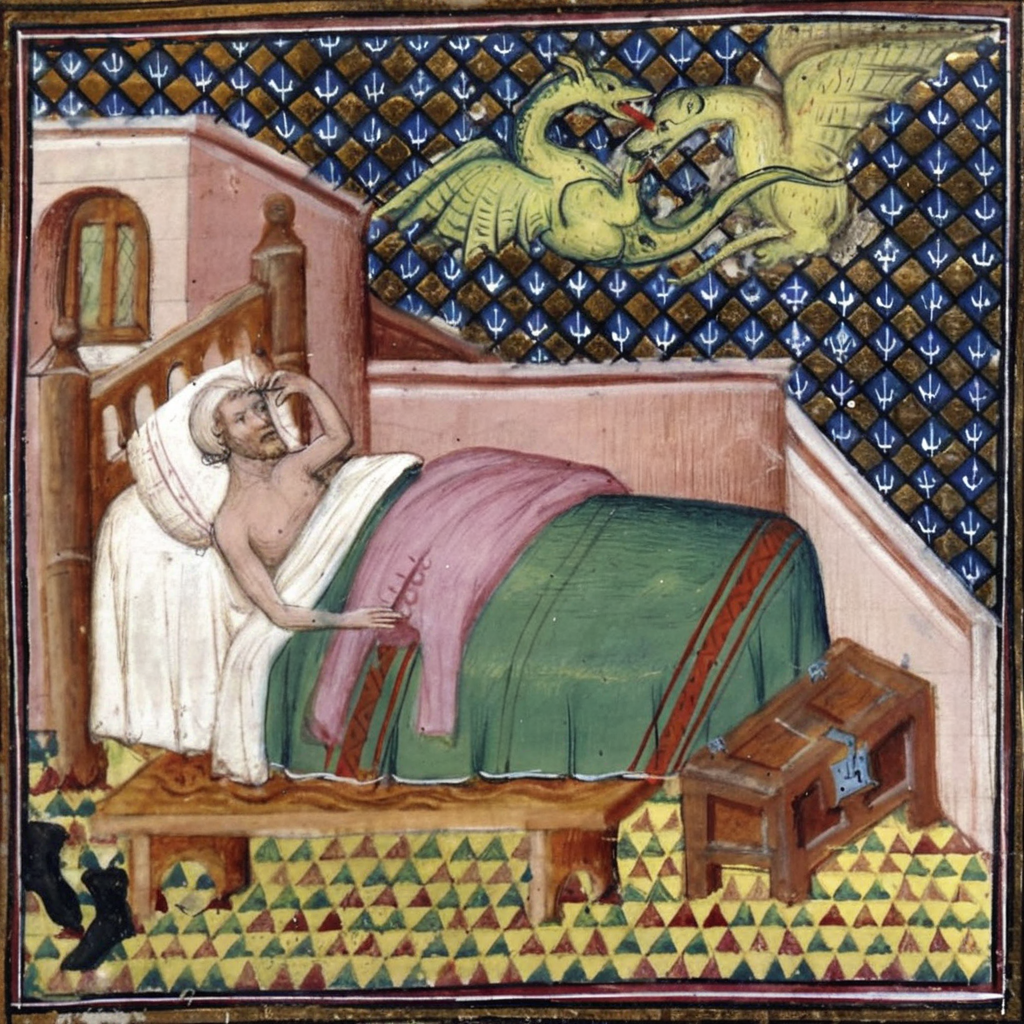
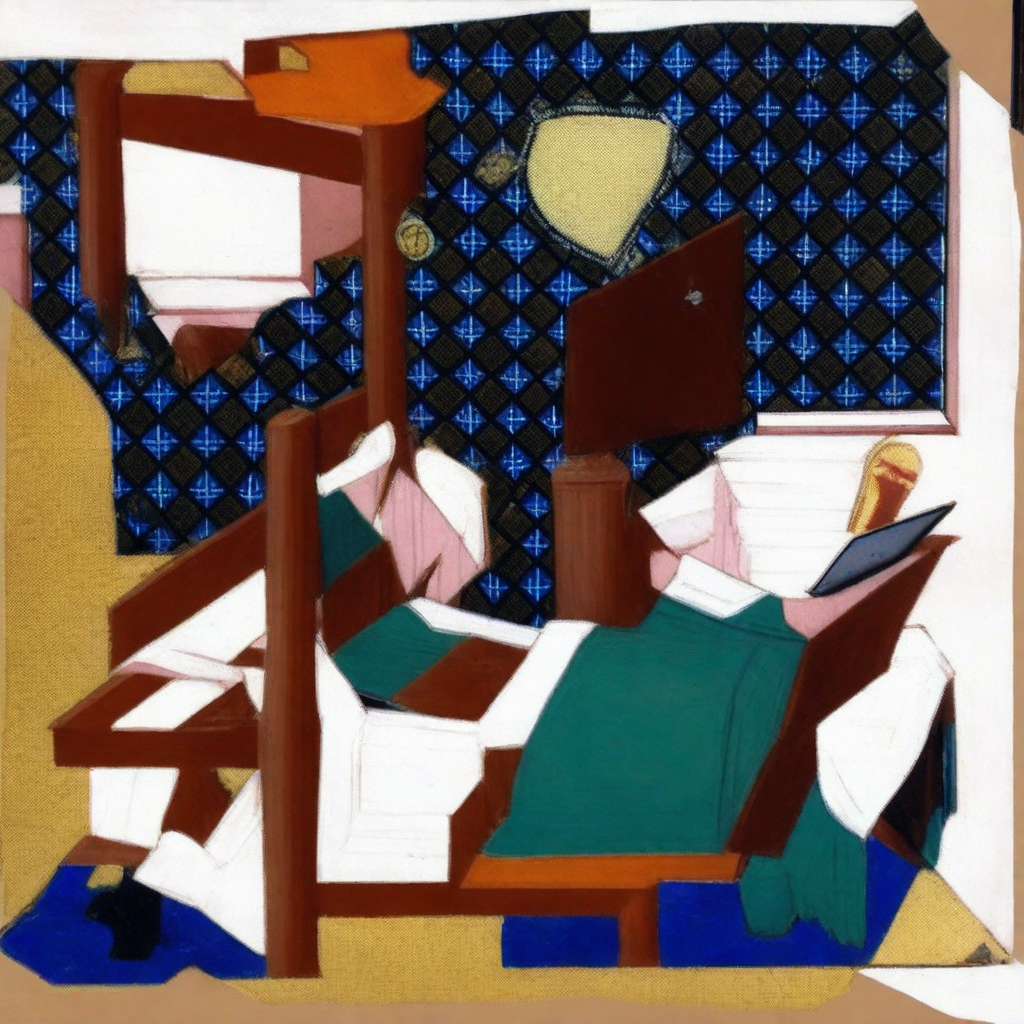
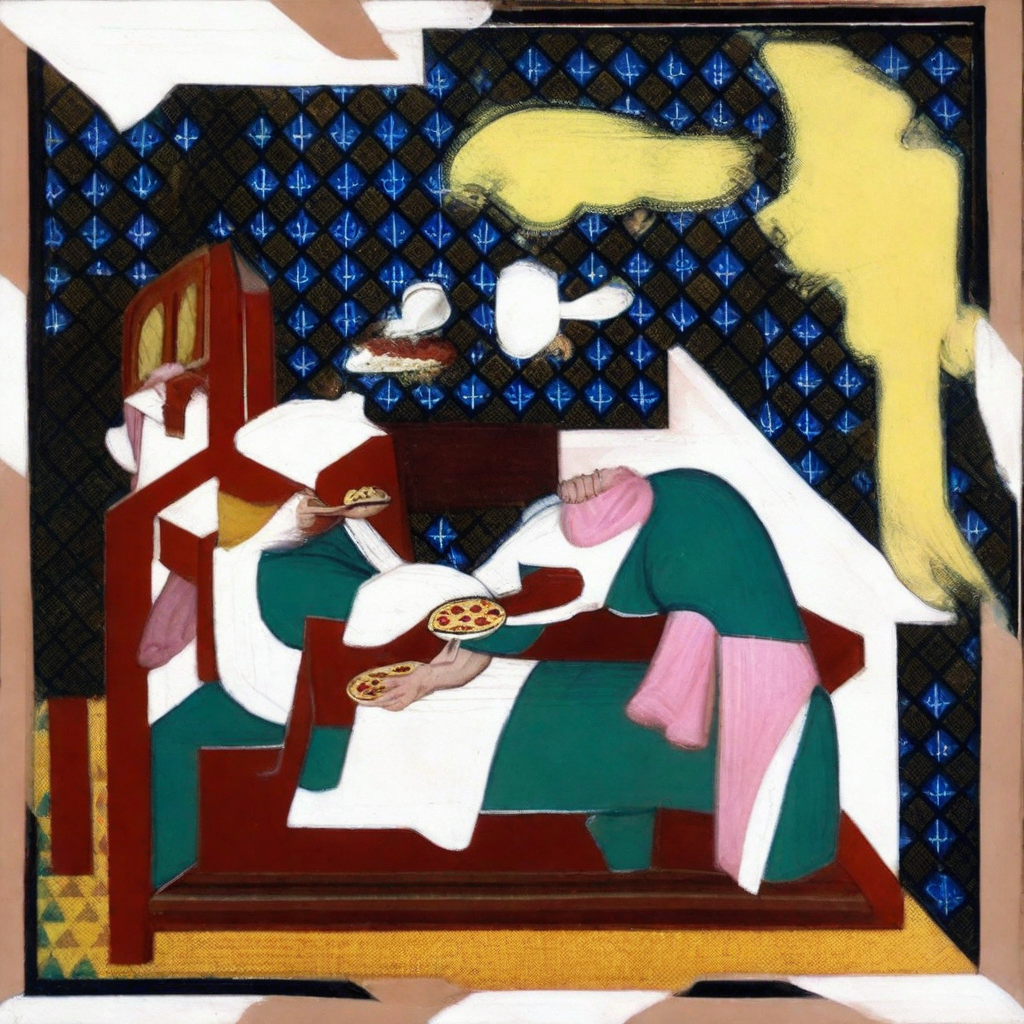
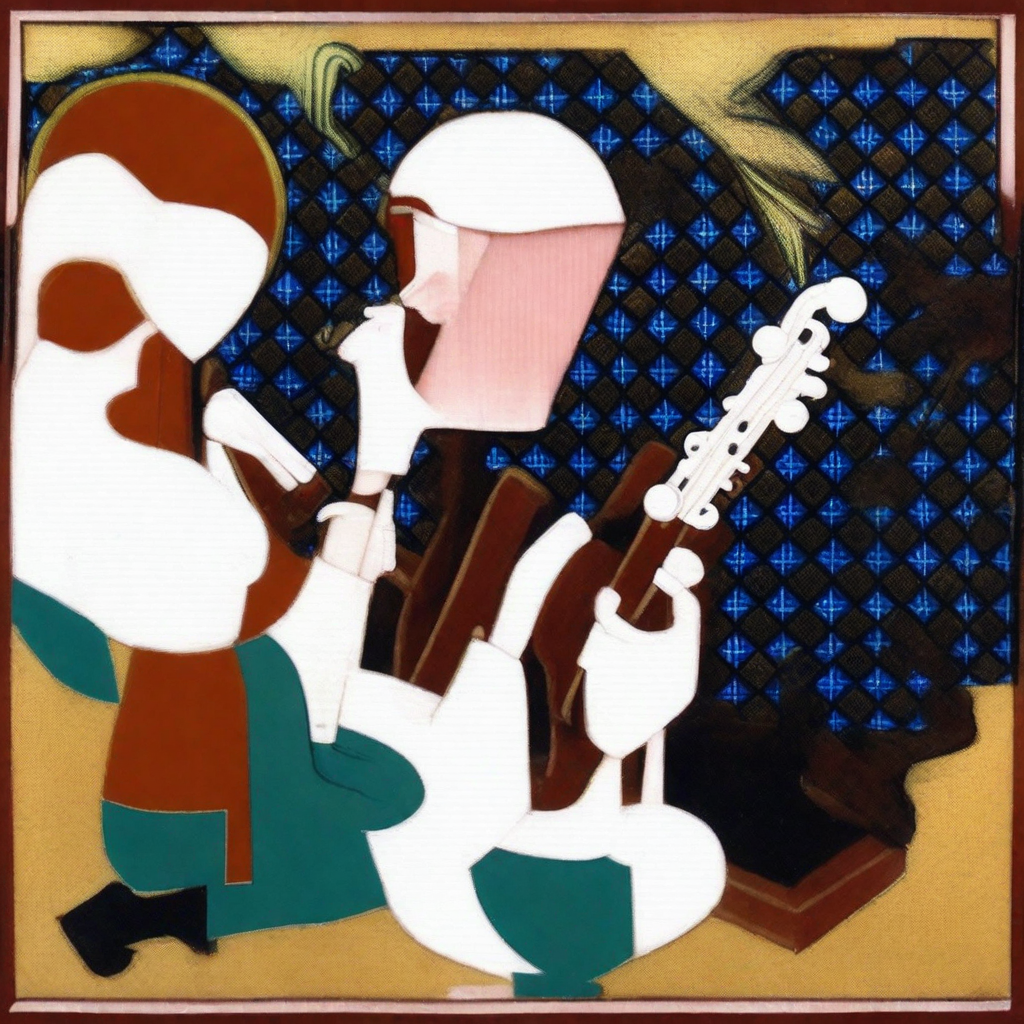

In [31]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(pipeline, ref_image, reference_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(31)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,            # Random Latent Vectors shape
                      device='cpu',                         # Latent Vectors on CPU.
                      generator=rand_gen,                   # Random Number Generator.
                      dtype=pipeline.unet.dtype,).to('cuda:0') # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = pipeline(
    prompts,                                 # Prompts to generate images for.
    latents=latents,                         # Latent Vectors to guide the generation of images.
    callback_on_step_end=inversion_callback, # Callback to update the latent vectors during the generation process.
    num_inference_steps=num_inference_steps, # Number of Inference Steps to generate the images.
    guidance_scale=guidance_scale).images              # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(reference_style) + 3)] for p in prompts])

## 7: STYLE-ALIGNED WITH CONTROLNET

On the following part of the Notebook, we will focus on extending the capabilities of the **Stable Diffusion XL (SDXL) ControlNet Pipeline** to generate images that are **Style Aligned**.

**ControlNet** is an advanced extension of diffusion models designed to enhance the control and flexibility of image generation processes. It is particularly useful for scenarios where detailed control over the generated images is required, such as integrating external conditions like depth maps, edge maps, or semantic maps. ControlNet achieves this by introducing a set of additional control mechanisms and networks that guide the image generation process in a more structured and interpretable manner.

Our contribution consists in applying the Style-Alignment idea to ControlNet, s.t. we are able both to generate images that are controlled through **Depth Images**, for example, but that are **Style Aligned**.

#### 7.1: DEPTH MAP FUNCTION

The following function is designed to generate a **Depth Map** from a given input image. This will be **one of the options** that we will have when **generating an Image** with the **ControlNet**. The depth map provides a representation of the distance of objects from the camera in the scene, which can be used in various image processing tasks. The function uses a depth estimation model to predict the depth of each pixel in the image and processes the depth data to make it suitable for further use.

The steps involved are:
- **1) Preprocess Image**: Convert the input image into a tensor suitable for processing by the depth estimation model.
- **2) Estimate Depth Map**: Use the depth estimation model to predict the depth map for the input image.
- **3) Interpolate Depth Map**: Resize the depth map to the desired dimensions using **BiCubic Interpolation**.
- **4) Normalize Depth Map**: Normalize the depth map values to a range between 0 and 1.
- **5) Convert to RGB Image**: Convert the normalized depth map into an RGB image format for visualization.

In [ ]:
def get_depth_map(image: Image, feature_processor: DPTImageProcessor, depth_estimator: DPTForDepthEstimation) -> Image:

    # 1) Preprocess Image: Convert the input image into a tensor suitable for processing by the depth estimation model.
    image = feature_processor(images=image, return_tensors="pt").pixel_values.to("cuda")

    # 2) Estimate Depth Map: Use the depth estimation model to predict the depth map for the input image.
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    # 3) Interpolate Depth Map: Resize the depth map to the desired dimensions using bicubic interpolation.
    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )

    # 4) Normalize Depth Map: Normalize the depth map values to a range between 0 and 1.
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)

    # 5) Convert to RGB Image: Convert the normalized depth map into an RGB image format for visualization.
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))

    return image

#### 7.2: CONCATENATION WITH ZERO TENSORS: UTIL FUNCTION

The following function is designed to concatenate zero tensors to the input tensor. This operation is useful for certain control tasks within the image generation process, where adding zero tensors helps in managing or normalizing the tensor data. We will use this function in ControlNet.

The steps involved are:
- **1) Calculate Batch Size** Determine the half batch size of the input tensor.
- **2) Create Zero Tensor**: Generate a zero tensor with the same shape as one sample of the input tensor.
- **3) Concatenate Tensors**: Concatenate the zero tensor to the input tensor at specific positions to create a new tensor.

In [ ]:
def concat_zero_control(control_reisduel: T) -> T:

    # 1) Calculate Batch Size: Determine the half batch size of the input tensor.
    b = control_reisduel.shape[0] // 2

    # 2) Create Zero Tensor: Generate a zero tensor with the same shape as one sample of the input tensor.
    zerso_reisduel = torch.zeros_like(control_reisduel[0:1])

    # 3) Concatenate Tensors: Concatenate the zero tensor to the input tensor at specific positions to create a new tensor.
    return torch.cat((zerso_reisduel, control_reisduel[:b], zerso_reisduel, control_reisduel[b:]))

#### 7.3: CONTROLNET MODEL

In the following, we will develop the **ControlNet Model Call**, that will be the one allowing us to perform **Image Generation** using a **Diffusion Models** with specific **Control Mechanisms**, with the **Style Aligned** application. It employs the ControlNet model to guide the generation process based on the input conditions and configurations. The function involves preparing input prompts, setting up the diffusion inversion process, configuring latent vectors, generating images, and displaying the results.

The steps involved are:
- **1) Initialize Variables**: Check ControlNet Module, by determining if the ControlNet module is compiled and retrieve the original module if necessary. We then Align Control Guidance Format to ensure that the control guidance start and end parameters are in the correct format (list) for further processing.
- **2) Check Inputs**: We perform Input Validation, by using the pipeline’s check_inputs method to validate all the provided inputs, ensuring they meet the expected formats and types.
- **3)Set Guidance Scale**: We assign Guidance Scale, by setting the guidance scale for the pipeline, which will be used during the diffusion process to adjust the influence of the guidance signal.
- **4) Define Call Parameters**: We determine Batch Size, based on the type of the prompt parameter (string, list, or embeddings) and we set the device.
- **5) Encode Input Prompt**: We then focus on retrieving LoRA Scale for Cross-Attention if provided in the cross_attention_kwargs. Here we encode both the main and secondary prompts (if provided) into embeddings using the pipeline’s encode_prompt method. This includes handling negative prompts and pooled embeddings.
- **6) Prepare Image**: We first Check the ControlNet Model Type, by verifying if the controlnet model is an instance of ControlNetModel. We process the input image, adjusting its size and format to match the requirements of the model and device.
- **7) Prepare Timesteps**: We set timesteps and configure the number of timesteps for the diffusion process using the scheduler.
- **8) Prepare Latent Variables**: We then identify the number of channels in the latent variables based on the UNet model configuration. Afterwards, we initialize Latents, using the pipeline’s prepare_latents method to initialize and adjust the shape of the latent variables, ensuring they match the expected input dimensions for the diffusion process. We then, optionally get Guidance Scale Embedding (for very famous images).
- **9) Prepare Extra Step kwargs**:  Define some additional arguments needed for the diffusion steps, such as the random number generator (generator) and the noise scale (eta).
- **10) Stack Embeddings**: Duplicate the prompt embeddings to match the number of images per prompt. Indeed, we stack the negative prompt embeddings, pooled negative prompt embeddings, and additional text embeddings.
- **11) Concatenate Embeddings**: Combine Negative and Positive Embeddings and time IDs.
- **12) Denoising Loop**: We now focus on the Denoising Loop. Here, we have several substeps:
    - **12.1) Calculate WarmUp Steps**: We determine the number of warmup steps based on the total number of timesteps and the scheduler’s order.
    - **12.2) Check the Module Compilation**: Check if the UNet and ControlNet modules are compiled and if the PyTorch version is >= 2.1.
    - **12.3) Prepare Additional Conditioning**: Set up additional conditioning arguments, including text embeddings and time IDs.
    - **12.3) Prepare ControlNet Prompt Embeddings and Additional Conditioning**: Duplicate the prompt embeddings for ControlNet. Duplicate the items in added_cond_kwargs for ControlNet.
    - **12.3) Loop Through Timesteps**:
        - Expand the latent variables for classifier-free guidance by concatenating them.
        - Adjust the latent model input for the current timestep using the scheduler’s scaling method. - Slice the latent model input to prepare it for ControlNet inference.
        - Calculate the conditioning scale for the current timestep.
        - Perform ControlNet inference if the conditioning scale is greater than 0. Adjust the mid-block and down-block residuals to ensure compatibility with zero control.
        - Use the UNet model to predict the noise residual.
        - Combine the unconditional and conditional noise predictions using the guidance scale.
        - Calculate the previous noisy sample (x_t -> x_t-1) using the scheduler’s step method.
        - Update the progress bar after each step.
- **13) Handle VAE UpCasting**: Check VAE Upcasting Requirement, by determining if the VAE needs to be upcasted to float32 for stability due to potential overflow issues in float16. Here, we need also to adjust the latents to match the dtype of the VAE’s post-quantization convolution parameters.
- **14) Decode Latents**: Use the VAE to decode the latents and generate the final image, scaling the latents appropriately.
- **15) Apply Watermark**: If a watermark is provided in the pipeline, apply it to the final image.
- **16) Post-process Image**: We convert to a desired format.
- **17) Free Up Resources**: Use the maybe_free_model_hooks method to offload all models from memory, freeing up resources.
- **18) Return Final Image**: Return the final processed image.


In [ ]:
@torch.no_grad()
def controlnet_call(
    pipeline: StableDiffusionXLControlNetPipeline,
    prompt: str | list[str] = None,
    prompt_2: str | list[str] | None = None,
    image: PipelineImageInput = None,
    height: int | None = None,
    width: int | None = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 5.0,
    negative_prompt: str | list[str] | None = None,
    negative_prompt_2: str | list[str] | None = None,
    num_images_per_prompt: int = 1,
    eta: float = 0.0,
    generator: torch.Generator | None = None,
    latents: TN = None,
    prompt_embeds: TN = None,
    negative_prompt_embeds: TN = None,
    pooled_prompt_embeds: TN = None,
    negative_pooled_prompt_embeds: TN = None,
    cross_attention_kwargs: dict[str, Any] | None = None,
    controlnet_conditioning_scale: float | list[float] = 1.0,
    control_guidance_start: float | list[float] = 0.0,
    control_guidance_end: float | list[float] = 1.0,
    original_size: tuple[int, int] = None,
    crops_coords_top_left: tuple[int, int] = (0, 0),
    target_size: tuple[int, int] | None = None,
    negative_original_size: tuple[int, int] | None = None,
    negative_crops_coords_top_left: tuple[int, int] = (0, 0),
    negative_target_size:tuple[int, int] | None = None,
    clip_skip: int | None = None,
) -> list[Image]:

    # 1) Check if the controlnet module is compiled and get the original module if so.
    controlnet = pipeline.controlnet._orig_mod if is_compiled_module(pipeline.controlnet) else pipeline.controlnet

    # Align format for control guidance parameters: Ensure control_guidance_start and control_guidance_end are lists of the same length.
    if not isinstance(control_guidance_start, list) and isinstance(control_guidance_end, list):
        control_guidance_start = len(control_guidance_end) * [control_guidance_start]
    elif not isinstance(control_guidance_end, list) and isinstance(control_guidance_start, list):
        control_guidance_end = len(control_guidance_start) * [control_guidance_end]
    elif not isinstance(control_guidance_start, list) and not isinstance(control_guidance_end, list):
        mult = 1
        control_guidance_start, control_guidance_end = (
            mult * [control_guidance_start],
            mult * [control_guidance_end],
        )

    # 2) Check inputs. Raise error if not correct: Validate the provided inputs to ensure they are correct and compatible.
    pipeline.check_inputs(
        prompt,
        prompt_2,
        image,
        1,
        negative_prompt,
        negative_prompt_2,
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
        controlnet_conditioning_scale,
        control_guidance_start,
        control_guidance_end,
    )

    # 3) Set the guidance scale for the pipeline: This will be used to control the influence of the guidance during the diffusion process.
    pipeline._guidance_scale = guidance_scale

    # 4) Define call parameters: Determine batch size based on the type of the prompt.
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1  # Single prompt case
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)  # Multiple prompts case
    else:
        batch_size = prompt_embeds.shape[0]  # Prompt embeddings case

    # Set the device for execution (e.g., CPU or GPU).
    device = pipeline._execution_device

    # 5) Encode input prompt: Retrieve the LoRA scale for cross attention if available.
    text_encoder_lora_scale = (
        cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
    )
    # Encode the input prompts into embeddings using the pipeline's text encoder
    (
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
    ) = pipeline.encode_prompt(
        prompt,
        prompt_2,
        device,
        1,
        True,
        negative_prompt,
        negative_prompt_2,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        pooled_prompt_embeds=pooled_prompt_embeds,
        negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
        lora_scale=text_encoder_lora_scale,
        clip_skip=clip_skip,
    )

    # 6) Prepare Image: Check if the controlnet model is an instance of ControlNetModel.
    if isinstance(controlnet, ControlNetModel):

        # Prepare the input image for the pipeline.
        image = pipeline.prepare_image(
            image=image,
            width=width,
            height=height,
            batch_size=1,
            num_images_per_prompt=1,
            device=device,
            dtype=controlnet.dtype,
            do_classifier_free_guidance=True,
            guess_mode=False,
        )
        # Get the height and width of the prepared image.
        height, width = image.shape[-2:]

        # Stack the image tensor to match the number of images per prompt.
        image = torch.stack([image[0]] * num_images_per_prompt + [image[1]] * num_images_per_prompt)
    else:
        assert False  # Raise an assertion error if controlnet is not an instance of ControlNetModel


    # 7) Prepare Timesteps: Set the timesteps for the diffusion process using the scheduler.
    pipeline.scheduler.set_timesteps(num_inference_steps, device=device)

    # Retrieve the timesteps from the scheduler.
    timesteps = pipeline.scheduler.timesteps

    # 8) Prepare latent variables: Determine the number of channels for the latent variables based on the UNet configuration.
    num_channels_latents = pipeline.unet.config.in_channels

    # Prepare the latents using the pipeline's method, which handles initialization and shape adjustments.
    latents = pipeline.prepare_latents(
        1 + num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
        latents,
    )

    # Optionally get Guidance Scale Embedding.
    timestep_cond = None

    # 9) Prepare extra step kwargs. Prepare additional arguments for the diffusion step, such as noise and eta values.
    extra_step_kwargs = pipeline.prepare_extra_step_kwargs(generator, eta)

    # Create tensor stating which controlnets to keep. Initialize a list to keep track of which controlnets to use at each timestep
    controlnet_keep = []
    # Loop through each timestep to determine which controlnets to use based on the guidance schedule.
    for i in range(len(timesteps)):
        keeps = [
            1.0 - float(i / len(timesteps) < s or (i + 1) / len(timesteps) > e)
            for s, e in zip(control_guidance_start, control_guidance_end)
        ]
        # Append the keep value for the current timestep.
        controlnet_keep.append(keeps[0] if isinstance(controlnet, ControlNetModel) else keeps)


    # Prepare added time ids & embeddings, and determine the original size of the image if not provided.
    if isinstance(image, list):
        original_size = original_size or image[0].shape[-2:]
    else:
        original_size = original_size or image.shape[-2:]

    # Set the target size for the image if not provided.
    target_size = target_size or (height, width)

    # Initialize additional text embeddings with pooled prompt embeddings.
    add_text_embeds = pooled_prompt_embeds

    # Determine the projection dimension for the text encoder.
    if pipeline.text_encoder_2 is None:
        text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
    else:
        text_encoder_projection_dim = pipeline.text_encoder_2.config.projection_dim

    # Generate additional time IDs based on the image and text encoder settings.
    add_time_ids = pipeline._get_add_time_ids(
        original_size,
        crops_coords_top_left,
        target_size,
        dtype=prompt_embeds.dtype,
        text_encoder_projection_dim=text_encoder_projection_dim,
    )

    # Generate negative additional time IDs if negative sizes are provided.
    if negative_original_size is not None and negative_target_size is not None:
        negative_add_time_ids = pipeline._get_add_time_ids(
            negative_original_size,
            negative_crops_coords_top_left,
            negative_target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
    else:
        negative_add_time_ids = add_time_ids

    # 10) Stack the prompt embeddings to match the number of images per prompt.
    prompt_embeds = torch.stack([prompt_embeds[0]] + [prompt_embeds[1]] * num_images_per_prompt)
    negative_prompt_embeds = torch.stack([negative_prompt_embeds[0]] + [negative_prompt_embeds[1]] * num_images_per_prompt)
    negative_pooled_prompt_embeds = torch.stack([negative_pooled_prompt_embeds[0]] + [negative_pooled_prompt_embeds[1]] * num_images_per_prompt)
    add_text_embeds = torch.stack([add_text_embeds[0]] + [add_text_embeds[1]] * num_images_per_prompt)

    # 11) Concatenate negative and positive prompt embeddings.
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
    add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

    # Move the embeddings and time IDs to the appropriate device (e.g., GPU).
    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.to(device).repeat(1 + num_images_per_prompt, 1)

    # Update the batch size to include the number of images per prompt.
    batch_size = num_images_per_prompt + 1




    # 12) Denoising loop: Calculate the number of warmup steps needed for the scheduler.
    num_warmup_steps = len(timesteps) - num_inference_steps * pipeline.scheduler.order

    # Check if UNet and ControlNet modules are compiled and if PyTorch version is >= 2.1.
    is_unet_compiled = is_compiled_module(pipeline.unet)
    is_controlnet_compiled = is_compiled_module(pipeline.controlnet)
    is_torch_higher_equal_2_1 = is_torch_version(">=", "2.1")

    # Prepare additional conditioning arguments with text embeddings and time IDs.
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

    # Prepare ControlNet prompt embeddings by duplicating the prompt embeddings.
    controlnet_prompt_embeds = torch.cat((prompt_embeds[1:batch_size], prompt_embeds[1:batch_size]))

    # Prepare ControlNet additional conditioning arguments by duplicating the items in added_cond_kwargs.
    controlnet_added_cond_kwargs = {key: torch.cat((item[1:batch_size], item[1:batch_size])) for key, item in added_cond_kwargs.items()}

    # Use the pipeline's progress bar to track progress.
    with pipeline.progress_bar(total=num_inference_steps) as progress_bar:

        # Loop through each timestep in the denoising process.
        for i, t in enumerate(timesteps):

            # Mark the beginning of a CUDA graph step if using compiled modules and PyTorch >= 2.1.
            if (is_unet_compiled and is_controlnet_compiled) and is_torch_higher_equal_2_1:
                torch._inductor.cudagraph_mark_step_begin()

            # Expand the latents if using classifier-free guidance by concatenating them.
            latent_model_input = torch.cat([latents] * 2)
            # Scale the model input for the current timestep.
            latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t)

            # Prepare input for ControlNet inference by slicing the latent model input.
            control_model_input = torch.cat((latent_model_input[1:batch_size], latent_model_input[batch_size+1:]))

            # Determine the conditioning scale for the current timestep.
            if isinstance(controlnet_keep[i], list):
                cond_scale = [c * s for c, s in zip(controlnet_conditioning_scale, controlnet_keep[i])]
            else:
                controlnet_cond_scale = float(controlnet_conditioning_scale)
                if isinstance(controlnet_cond_scale, list):
                    controlnet_cond_scale = controlnet_cond_scale[0]
                cond_scale = controlnet_cond_scale * controlnet_keep[i]

            # Perform ControlNet inference if conditioning scale is greater than 0.
            if cond_scale > 0:
                down_block_res_samples, mid_block_res_sample = pipeline.controlnet(
                    control_model_input,
                    t,
                    encoder_hidden_states=controlnet_prompt_embeds,
                    controlnet_cond=image,
                    conditioning_scale=cond_scale,
                    guess_mode=False,
                    added_cond_kwargs=controlnet_added_cond_kwargs,
                    return_dict=False,
                )

                # Ensure mid block residuals are compatible with zero control.
                mid_block_res_sample = concat_zero_control(mid_block_res_sample)
                down_block_res_samples =  [concat_zero_control(down_block_res_sample) for down_block_res_sample in down_block_res_samples]
            else:
                mid_block_res_sample = down_block_res_samples = None

            # Predict the noise residual using the UNet model.
            noise_pred = pipeline.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=cross_attention_kwargs,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]

            # Perform guidance by combining unconditional and conditional noise predictions.
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample (x_t -> x_t-1).
            latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

            # Update the progress bar after each step.
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipeline.scheduler.order == 0):
                progress_bar.update()



    # 13) Manually handle VAE upcasting for max memory savings: Check if VAE needs to be upcasted to float32 for stability.
    if pipeline.vae.dtype == torch.float16 and pipeline.vae.config.force_upcast:

        pipeline.upcast_vae()  # Upcast VAE to float32.
        # Convert latents to the dtype of the VAE's post-quantization convolution parameters.
        latents = latents.to(next(iter(pipeline.vae.post_quant_conv.parameters())).dtype)

    # Ensure the VAE is in float32 mode, as it may overflow in float16.
    needs_upcasting = pipeline.vae.dtype == torch.float16 and pipeline.vae.config.force_upcast

    # 14) Decode Latents: If upcasting is required, upcast the VAE and convert latents accordingly.
    if needs_upcasting:
        pipeline.upcast_vae()  # Upcast VAE to float32
        latents = latents.to(next(iter(pipeline.vae.post_quant_conv.parameters())).dtype)

    # Decode the latents to generate the final image.
    image = pipeline.vae.decode(latents / pipeline.vae.config.scaling_factor, return_dict=False)[0]

    # 15) Apply Watermarks: If upcasting was performed, cast the VAE back to float16.
    if needs_upcasting:
        pipeline.vae.to(dtype=torch.float16)

    # Apply watermark to the image if a watermark is provided in the pipeline.
    if pipeline.watermark is not None:
        image = pipeline.watermark.apply_watermark(image)

    # 16) Post-process Image: Post-process the image to convert it to the desired output format (e.g., PIL).
    image = pipeline.image_processor.postprocess(image, output_type='pil')

    # 17) Free Up Resources: Offload all models from memory to free up resources.
    pipeline.maybe_free_model_hooks()

    # 18) Return Final Image: Return the final processed image.
    return image